In [1]:
import warnings
warnings.filterwarnings('ignore')
from utils import future, continuous_future, history, bundle_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from strategies.contracts import contracts

In [3]:
con = [continuous_future(contract,
                          offset=0,
                          adjustment='mul',
                          roll_style='volume')
        for contract in contracts]

In [4]:
his = history(assets=con, 
              end_dt=pd.Timestamp('2018-10-31', tz='UTC'),
              bar_count=252,
              frequency='1d',
              field='price',
              data_frequency='daily'
             )
his.columns = his.columns.map(lambda x: x.root_symbol)

In [5]:
returns = np.log(his.pct_change()+1)[1:]

In [6]:
corr = returns.corr()

In [7]:
# quick sanity check
print('S&P vs NAS: ', corr.loc['ES', 'NQ'])
print('S&P vs. oil: ', corr.loc['ES', 'CL'])
print('Treasuries vs. Fed Funds: ', corr.loc['US', 'FF'])
print('Gold vs. Eurodollar:', corr.loc['GC', 'ED'])
print('Gold vs. Treasuries:', corr.loc['GC', 'US'])

S&P vs NAS:  0.9189509983566513
S&P vs. oil:  0.28283398823504313
Treasuries vs. Fed Funds:  0.26280721338468555
Gold vs. Eurodollar: -0.022227705799909885
Gold vs. Treasuries: 0.21365079303936188


In [8]:
# pull out sector data from sqlite
import sqlalchemy as sa
d = bundle_data.asset_finder.futures_root_symbols.c
def get_sector(root_symbol):
    fields = (d.sector,)
    sector = sa.select(fields).where(
            d.root_symbol == root_symbol).execute().scalar()
    return sector.split('/')
def get_name(root_symbol):
    fields = (d.description,)
    name = sa.select(fields).where(
            d.root_symbol == root_symbol).execute().scalar()
    return name

In [9]:
get_sector('ES')

['Equities', 'US Index']

In [10]:
get_name('ES')

'E-mini S&P 500 Futures'

# Contract Reference List 

In [11]:
sect_dict = {symbol: get_sector(symbol) for symbol in contracts}
sectors = pd.DataFrame(sect_dict).T
sectors.columns = ['sector', 'sub-sector']
sectors['name'] = sectors.index.map(get_name)
sectors

,sector,sub-sector,name
AD,FX,Majors,Australian Dollar Futures
BO,Agriculture,Grain And Oilseed,Soybean Oil Futures
BP,FX,Majors,British Pound Futures
BZ,Energy,Crude Oil,Brent Crude Oil Financial Futures
CD,FX,Majors,Canadian Dollar Futures
CL,Energy,Crude Oil,Crude Oil Futures
DA,Agriculture,Dairy,Class III Milk Futures
EC,FX,Majors,Euro FX Futures
ED,Interest Rate,Stir,Eurodollar Futures
EH,Energy,Ethanol,Ethanol Futures


In [12]:
sns.set_style('whitegrid')
#colormap = sns.diverging_palette(220, 10, as_cmap=True)
colormap = sns.diverging_palette(133, 10, n=5, as_cmap=True)

# Single Contract Correlation by Sector

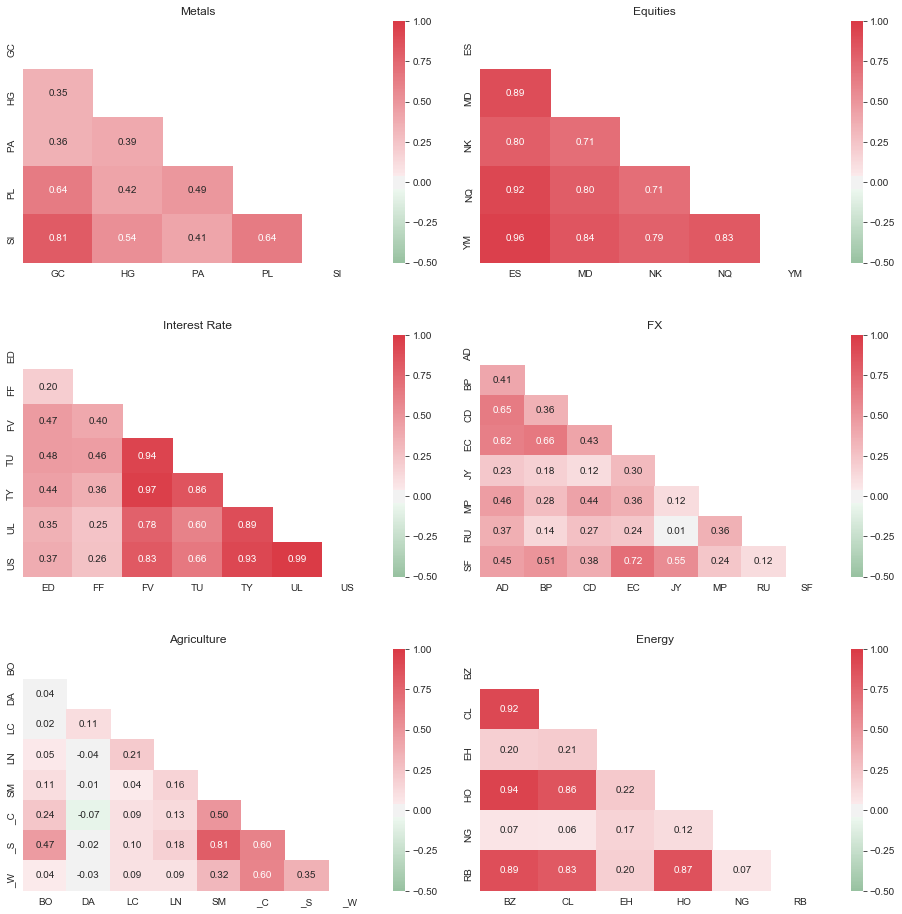

In [13]:
corr_by_sector = {}
for sector, symbols in sectors.groupby('sector').groups.items():
    corr_by_sector[sector] = returns[symbols].corr()

fig = plt.figure(figsize=(16,16))
fig.subplots_adjust(hspace=.3, wspace=.05)
rows = np.ceil(len(corr_by_sector.keys())/2)
index = 0
for sector, table in corr_by_sector.items():
    index += 1
    dropSelf = np.zeros_like(table)
    dropSelf[np.triu_indices_from(dropSelf)] = True
    ax = fig.add_subplot(rows, 2, index)
    sns.heatmap(table, cmap=colormap, annot=True, fmt=".2f", 
                vmin=-.5, vmax=1, center=0, mask=dropSelf, ax=ax).set_title(sector);

# Single Contract Correlation by Sub-sector

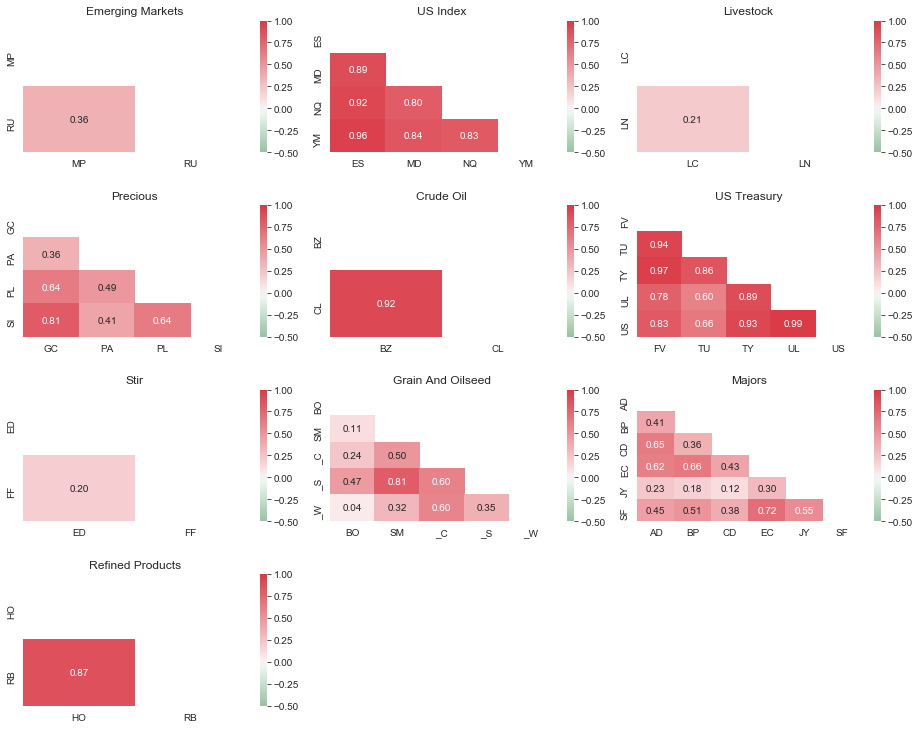

In [14]:
corr_by_sub_sector = {}
for sector, symbols in sectors.groupby('sub-sector').groups.items():
    corr_by_sub_sector[sector] = returns[symbols].corr()

fig = plt.figure(figsize=(16,16))
fig.subplots_adjust(hspace=.4, wspace=.1)
rows = np.ceil(len(corr_by_sub_sector.keys())/3)
index = 0
for sector, table in corr_by_sub_sector.items():
    if table.shape == (1,1):
        continue
    index += 1
    dropSelf = np.zeros_like(table)
    dropSelf[np.triu_indices_from(dropSelf)] = True
    ax = fig.add_subplot(rows, 3, index)
    sns.heatmap(table, cmap=colormap, annot=True, fmt=".2f", 
                vmin=-.5, vmax=1, center=0, mask=dropSelf, ax=ax).set_title(sector);

# Sector Indices Correlation

In [15]:
sector_index = pd.DataFrame()
for sector, symbols in sectors.groupby('sector').groups.items():
    df = his[symbols].copy()
    df= df.pct_change()[1:]
    ind = df.apply(lambda x: np.average(x), axis=1)
    sector_index[sector] = ind

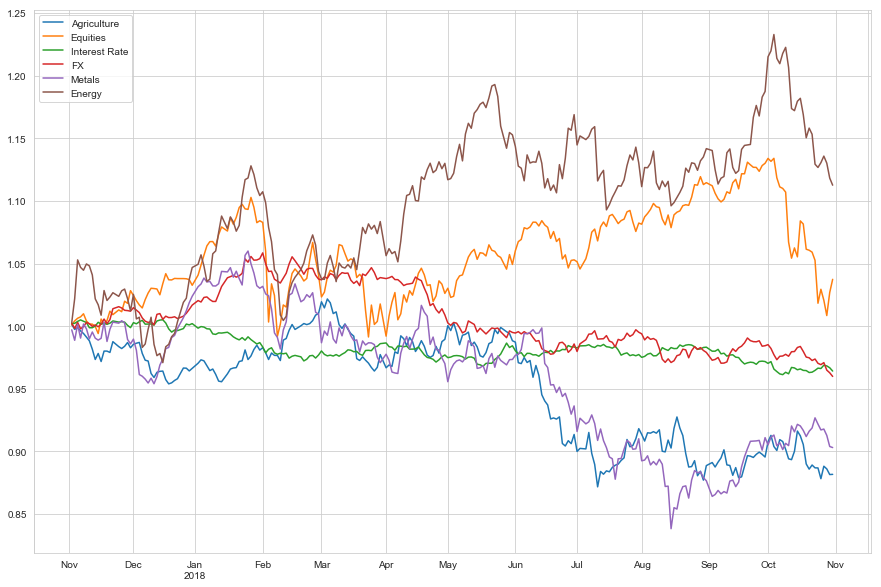

In [16]:
(sector_index + 1).cumprod().plot(grid=True, figsize=(15,10));

In [17]:
sector_returns = np.log(sector_index + 1)

In [18]:
sector_corr = sector_returns.corr()

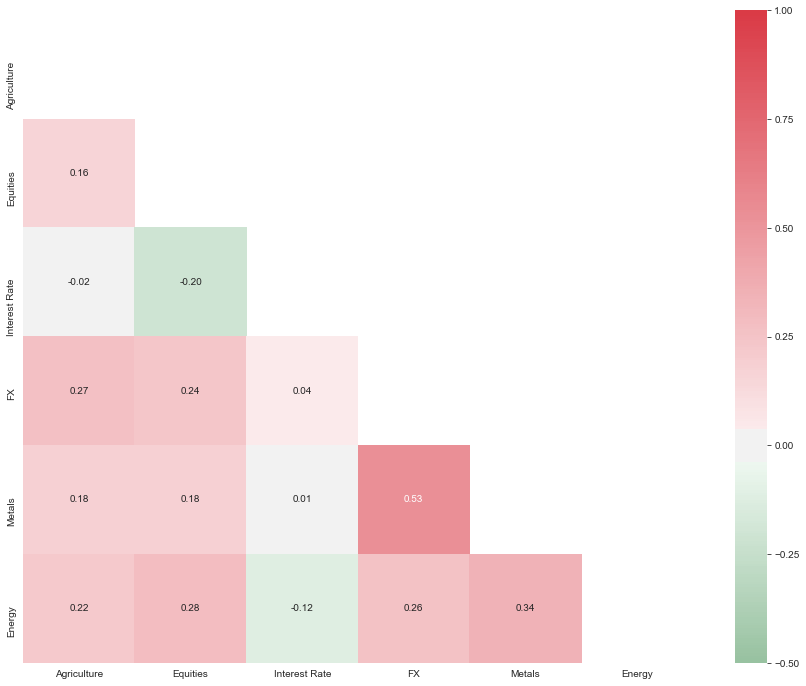

In [19]:
plt.figure(figsize=(15,12))
dropSelf = np.zeros_like(sector_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
sns.heatmap(sector_corr, cmap=colormap, annot=True, fmt=".2f", vmin=-.5, vmax=1, center=0, mask=dropSelf);

# Sub-sector Indices Correlation

In [20]:
sub_sector_index = pd.DataFrame()
for sector, symbols in sectors.groupby('sub-sector').groups.items():
    df = his[symbols].copy()
    df=df.pct_change()[1:]
    ind = df.apply(lambda x: np.average(x), axis=1)
    sub_sector_index[sector] = ind

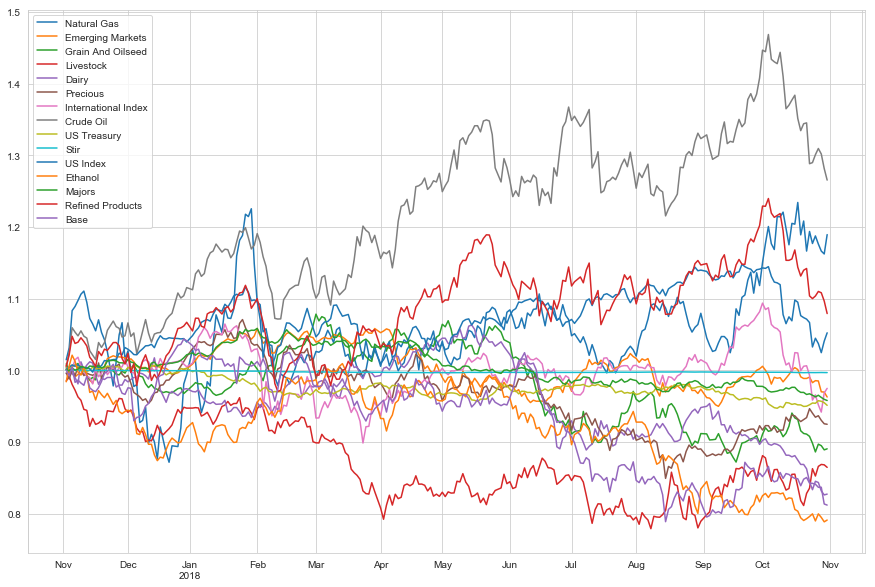

In [21]:
(sub_sector_index + 1).cumprod().plot(grid=True, figsize=(15,10));

In [22]:
sub_sector_returns = np.log(sub_sector_index + 1)

In [23]:
sub_sector_corr = sub_sector_returns.corr()

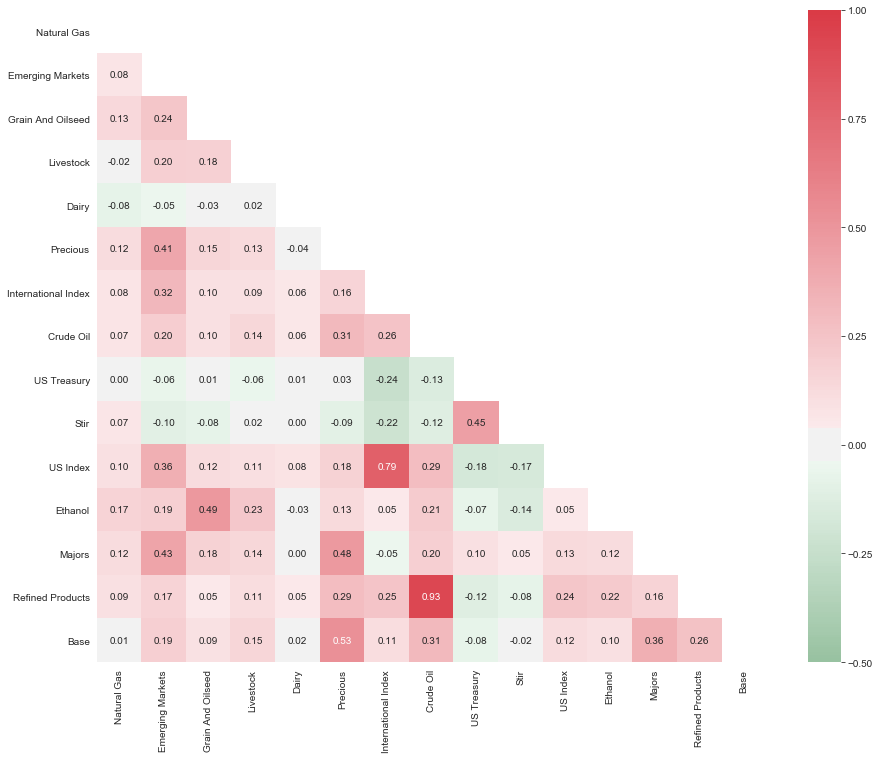

In [24]:
plt.figure(figsize=(15,12))
dropSelf = np.zeros_like(sub_sector_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
sns.heatmap(sub_sector_corr, cmap=colormap, annot=True, fmt=".2f", vmin=-.5, vmax=1, center=0, mask=dropSelf);

# Correlation Stability Over Time

In [25]:
periods = 2520 * 2 # about 20 years
long_history = history(assets=con, 
                       end_dt=pd.Timestamp('2018-10-31', tz='UTC'),
                       bar_count=periods,
                       frequency='1d',
                       field='price',
                       data_frequency='daily'
                      )
long_history.columns = long_history.columns.map(lambda x: x.root_symbol)

In [26]:
sample = ['ES', 'TY', 'CL', 'GC',] # up to 4 to make number of charts reasonable

In [27]:
def correlation_history(pair, method='pearson'):
    ret = np.log(long_history[pair].pct_change()+1)[1:]
    correlations = pd.Series()
    for i in range(periods-252):
        period_ret = ret[i: 252+i].copy()
        correlations.set_value(period_ret.index[-1], period_ret.corr(method=method).iloc[0,1])
    return correlations

In [28]:
def get_correlations(method='pearson'):
    corr_dict = {}
    for item in sample:
        for other in sample:
            if item == other:
                continue
            key = '{} ({}) vs. {} ({})'.format(item, get_name(item), other, get_name(other))
            corr_dict[key] = correlation_history([item, other], method=method)
    return corr_dict

In [29]:
def draw_charts(corr_dict):
    fig = plt.figure()
    cols = 3
    rows = int(np.ceil(len(corr_dict.keys())/cols))
    fig, ax = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(17,10))

    index = 0
    for symbol, table in corr_dict.items():
        row = int(index/3)
        col = index % 3
        ax[row, col].plot(table)
        ax[row, col].grid(True)
        ax[row, col].set_title(symbol)
        index += 1

In [30]:
pearson_corr = get_correlations()
spearman_corr = get_correlations('spearman')

Simple correlations

<Figure size 432x288 with 0 Axes>

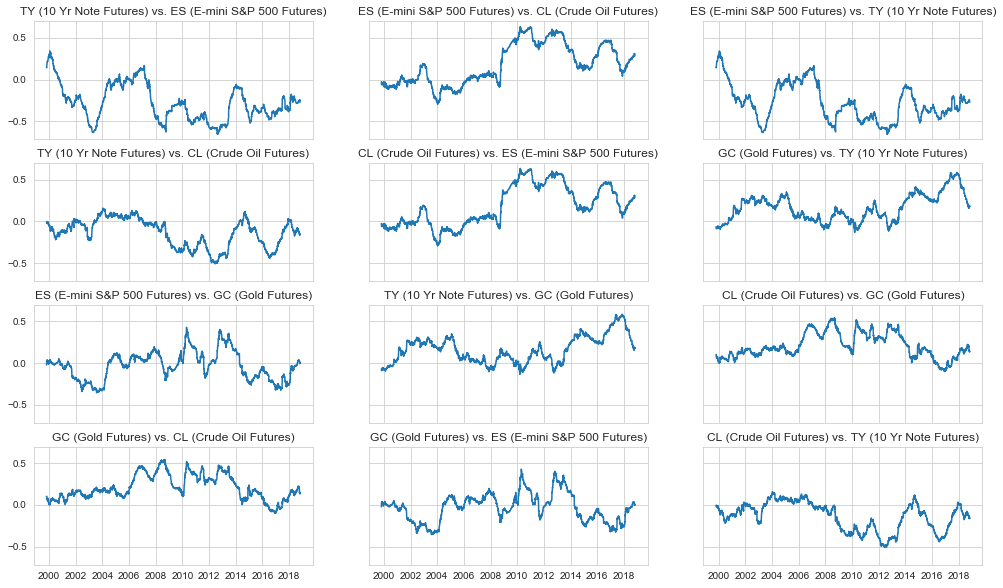

In [31]:
draw_charts(pearson_corr)

Spearman rank correlations

<Figure size 432x288 with 0 Axes>

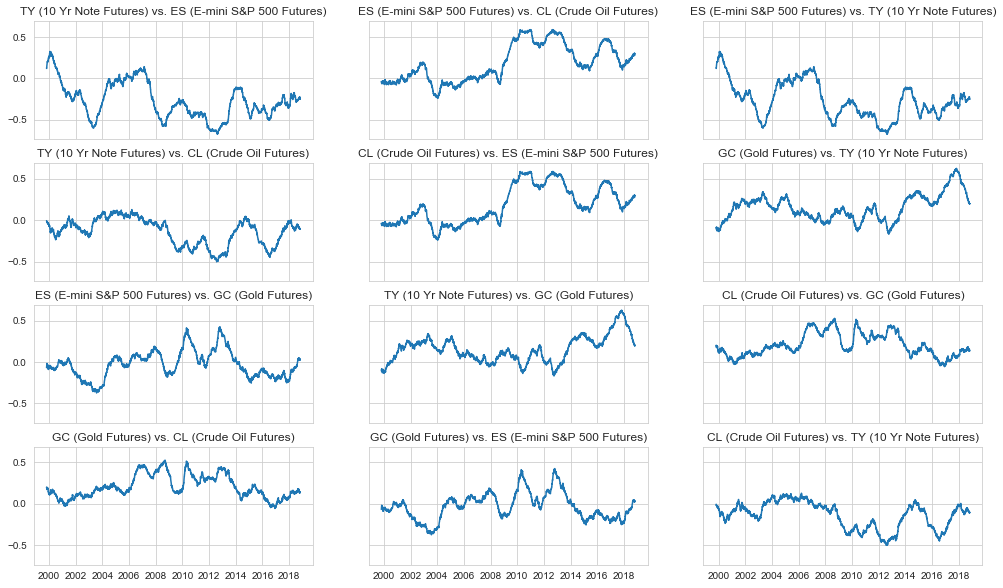

In [32]:
draw_charts(spearman_corr)

# Auto-correlation

In [33]:
returns.apply(lambda x: x.autocorr(25)).sort_values(ascending=False)

CL    0.116830
HO    0.103160
ED    0.093002
BZ    0.088215
LN    0.066670
TU    0.054639
FV    0.045478
RB    0.039574
YM    0.038319
NK    0.036286
TY    0.034099
LC    0.032557
HG    0.031665
NQ    0.031344
ES    0.028262
JY    0.020785
DA    0.016361
_W    0.013929
PL    0.007572
FF    0.003304
MP   -0.000472
RU   -0.001741
SM   -0.009775
SI   -0.010520
GC   -0.018734
PA   -0.021377
UL   -0.029990
US   -0.033133
AD   -0.045994
MD   -0.046537
EH   -0.053269
CD   -0.073011
_C   -0.077760
BO   -0.091647
EC   -0.102347
SF   -0.110547
_S   -0.115836
BP   -0.123837
NG   -0.156592
dtype: float64

Autocorrelations by number of lookaback periods

In [34]:
autocorrs = pd.DataFrame()
for p in range(5, 105, 5):
    autocorrs[p] = returns.apply(lambda x: x.autocorr(p))
autocorrs = autocorrs.T

In [35]:
autocorrs

,ED,TY,FV,TU,US,FF,UL,ES,NQ,YM,...,BO,SM,LC,LN,DA,GC,HG,SI,PL,PA
5,0.027884,0.063458,0.061188,-0.005020,0.025537,-0.015072,0.004075,-0.089643,-0.165068,-0.079411,...,0.046932,-0.003070,-0.026050,0.078233,-0.038877,-0.010048,-0.016008,0.015228,-0.070204,-0.019944
10,-0.040537,-0.016714,-0.014338,-0.070996,-0.005241,-0.075742,0.023430,0.040613,0.084415,0.023468,...,-0.047069,-0.044147,-0.039327,-0.151289,0.120505,-0.131887,-0.075445,-0.154772,-0.075670,-0.131868
15,0.042130,0.029050,0.019392,0.014473,0.004342,0.066061,-0.011546,-0.044024,-0.063864,-0.032183,...,0.053031,0.026932,-0.106085,0.020532,0.036229,0.045880,-0.009072,-0.032131,0.035705,-0.023609
20,0.007699,0.045124,0.060281,0.034925,0.032460,-0.107017,0.033769,-0.054509,-0.042854,-0.074446,...,-0.155709,-0.004310,0.077300,-0.031769,0.128121,0.056209,-0.104083,-0.005211,-0.095531,0.063813
25,0.093002,0.034099,0.045478,0.054639,-0.033133,0.003304,-0.029990,0.028262,0.031344,0.038319,...,-0.091647,-0.009775,0.032557,0.066670,0.016361,-0.018734,0.031665,-0.010520,0.007572,-0.021377
30,0.029527,-0.000229,0.004226,0.043165,0.024211,0.035272,0.057018,0.040196,0.019441,0.001242,...,0.047748,-0.055999,-0.047831,-0.002772,-0.024288,-0.152399,0.030488,-0.075206,0.000664,-0.136814
35,0.015899,0.028435,0.022622,0.006868,0.022301,0.006319,0.001158,0.018606,0.031644,-0.003144,...,-0.051661,-0.042983,-0.056849,0.058433,-0.098001,0.023853,0.119754,-0.023004,0.038476,0.049638
40,-0.004619,0.114853,0.137102,0.114012,0.094199,0.045293,0.086316,0.012506,-0.013765,-0.004760,...,0.121679,0.022048,-0.025837,0.077229,-0.088805,0.001187,0.019375,0.059735,0.090229,0.068635
45,-0.114373,0.005681,0.037371,0.041686,-0.048589,0.036006,-0.053024,0.049077,0.049469,0.032262,...,0.018964,-0.064652,0.021596,0.082111,0.061430,0.009130,0.055946,0.085797,-0.022208,-0.050041
50,-0.013211,-0.058668,-0.069383,-0.068975,-0.068077,0.027912,-0.065313,-0.047780,-0.053544,-0.024986,...,-0.004893,0.067151,0.072138,-0.028432,-0.050129,-0.035575,-0.179390,-0.169291,-0.131110,-0.044112


Maximum autocorrelations

In [36]:
highs = pd.DataFrame()
highs['autocorr'] = autocorrs.apply(lambda x: x.max())
highs['periods'] = autocorrs.idxmax()
highs.sort_values('autocorr', ascending=False, inplace=True)
highs

,autocorr,periods
RB,0.190236,20
EC,0.182367,55
LC,0.179730,75
HO,0.175760,20
BO,0.175750,55
AD,0.168082,55
EH,0.154281,50
SF,0.152269,20
LN,0.150322,70
CL,0.145210,55


In [37]:
highs.describe()

,autocorr,periods
count,39.000000,39.000000
mean,0.128081,57.051282
std,0.030000,28.137771
min,0.066061,10.000000
25%,0.110805,32.500000
50%,0.127574,55.000000
75%,0.142836,80.000000
max,0.190236,100.000000


Minimum autocorrelations

In [38]:
lows = pd.DataFrame()
lows['autocorr'] = autocorrs.apply(lambda x: x.min())
lows['periods'] = autocorrs.idxmin()
lows.sort_values('autocorr', inplace=True)
lows

,autocorr,periods
EC,-0.257186,85
SF,-0.211253,65
BP,-0.183785,85
HG,-0.179390,50
CL,-0.175211,85
MP,-0.174055,65
SI,-0.169291,50
_C,-0.168643,95
NQ,-0.165068,5
PA,-0.158067,60


In [39]:
lows.describe()

,autocorr,periods
count,39.000000,39.000000
mean,-0.136877,59.615385
std,0.037377,32.492603
min,-0.257186,5.000000
25%,-0.157329,27.500000
50%,-0.133116,65.000000
75%,-0.106812,87.500000
max,-0.079411,100.000000


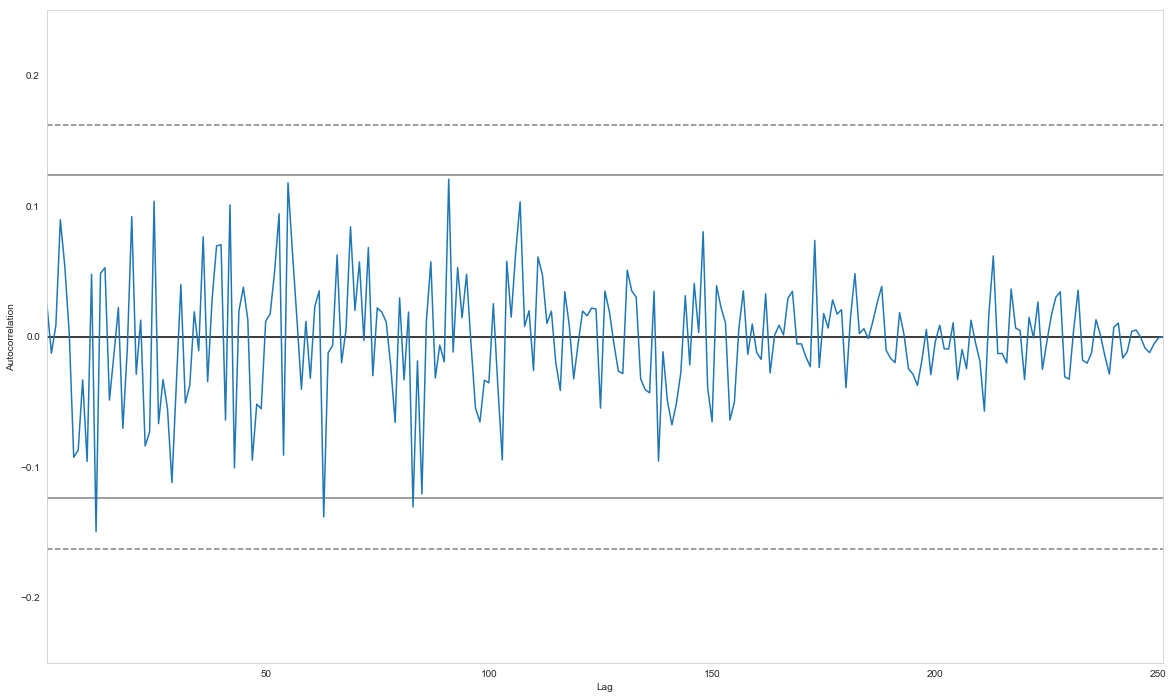

In [40]:
plt.figure(figsize=(20, 12))
pd.plotting.autocorrelation_plot(returns['CL'])
plt.ylim(-.25, .25);
